# analyzing aggregated assistive technology data

In [1]:
from pathlib import Path
if not Path("research").exists():
  !git clone https://github.com/a11yhood/research
try:
  import pandas
except ModuleNotFoundError:
  %pip install pandas nltk wordcloud toolz
import pandas, nltk, wordcloud, numpy
from pandas import *
from toolz.curried import *
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pandas.read_json("research/at.json.gz")

In [3]:
    def word_cloud(freq): return (
        __import__("wordcloud").WordCloud()
        .generate_from_frequencies(dict(freq))
        .to_image()
    )

In [4]:
    counts = df.tags.explode().str.lower().value_counts()
    (tags := counts.head(100)).to_frame("tags").T.style.set_caption(
        "aggregated tags from all of the services"
    )

tags,written pattern,assistive technology,medical,in the round,one piece,therapy aid,other,worked flat,accessibility,adaptive,medical device accessory,seamless,adult,phototutorial,screen reader,unisex,seamed,3 dimensional,ribbed,assistivetech,bottom up,medical device access,disability,stripes colorwork,female,teen,animal,other accessibility,video tutorial,chart,openat,textured,amigurumi,rectangle,child,assistive device,a11y,top down,mature,muff,top cuff down,python,arduino,mid-calf,buttonholes,bobble or popcorn,wcag,wai aria,buttoned,assistive,icord,aac,cables,kitchener,nvda,toe up,toddler,reversible,open source,3d printing,ai,preemie,technology,android,male,ipad,machine learning,communication,heel flap,"beanie, toque",baby,schematic,disabled,shawl / wrap,newborn size,sideways,artificial intelligence,assistant,speech,square,lace,post stitch,fingerless gloves/mitts,three needle bind,slipped stitches,fitted,joystick,speech therapy,gusset,rehabilitation,mobility aid accessory,text to speech,wheelchair,occupational therapy,ios,javascript,voice assistant,eye tracking,game,beads
tags,505,392,281,244,209,196,186,174,162,162,150,141,141,118,115,109,100,87,75,74,74,58,57,56,56,55,52,50,48,47,46,46,45,45,35,34,34,34,33,31,31,29,27,27,26,25,25,25,24,24,23,23,20,19,19,19,19,18,18,18,18,18,17,16,16,15,15,15,15,15,15,15,14,14,14,14,14,14,14,13,13,13,13,13,13,12,12,12,12,12,12,12,12,12,11,11,11,11,11,11


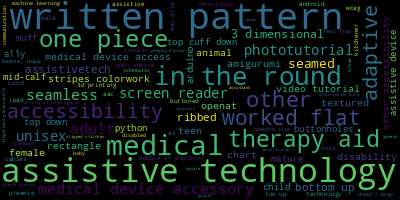

In [5]:
tags.pipe(word_cloud)

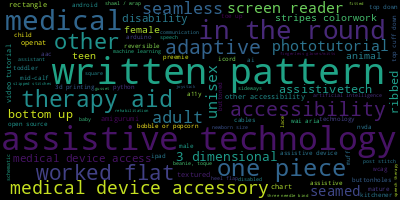

In [6]:
    counts.pipe(word_cloud)

In [7]:
    words = (
        df.description.dropna()
        # .str.lower()
        .apply(nltk.tokenize.sent_tokenize)
        .explode()
        .dropna()
        .apply(nltk.tokenize.word_tokenize)
        .apply(compose(lambda x: pipe(x, map(list), partial(DataFrame, columns="word pos".split())), nltk.pos_tag))
        # .str.lower()
    )

    words = pandas.concat(pipe(words.items(), dict)).reset_index(-1, drop=True)
    words["word"] = words["word"].str.lower()

In [8]:
    words = words.assign(
        stop=words.word.apply((
            "http https nbsp".split() +
            nltk.corpus.stopwords.words("english")
        ).__contains__),
        alpha=words.word.apply(compose(str.isalpha, get(0)))
    )
    words = words.assign(
        valid=numpy.logical_and(~words.stop, words.alpha)
    )

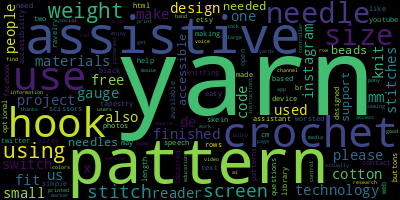

In [9]:
  words[words.valid].word.value_counts().pipe(word_cloud)